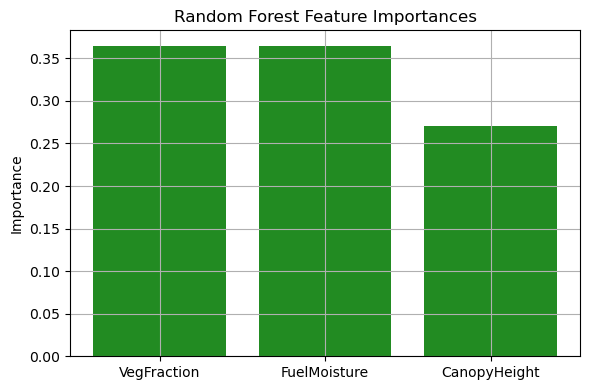

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# --- Simulate aligned raster layers (100x100 pixels) ---
np.random.seed(42)
shape = (100, 100)

veg_frac = np.clip(np.random.normal(0.5, 0.2, shape), 0, 1)       # Sub-pixel vegetation
fuel_moisture = np.clip(np.random.normal(0.6, 0.15, shape), 0, 1) # From EMIT
canopy_height = np.random.uniform(0, 25, shape)                   # From LVIS

# --- Simulate burn severity (dNBR) as a weighted function + noise ---
true_weights = [0.5, -0.7, -0.2]  # hypothetical influence
burn_severity = (
    true_weights[0] * veg_frac +
    true_weights[1] * fuel_moisture +
    true_weights[2] * (canopy_height / 25.0) +
    np.random.normal(0, 0.1, shape)
)
burn_severity = np.clip(burn_severity, 0, 1)

# --- Flatten arrays for modeling ---
X = np.stack([veg_frac, fuel_moisture, canopy_height], axis=-1).reshape(-1, 3)
y = burn_severity.flatten()

# --- Filter NaNs (if any) ---
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X_clean, y_clean = X[mask], y[mask]

# --- Train Random Forest ---
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_clean, y_clean)
y_pred = model.predict(X_clean)

# --- Feature importance ---
features = ["VegFraction", "FuelMoisture", "CanopyHeight"]
importances = model.feature_importances_

plt.figure(figsize=(6,4))
plt.bar(features, importances, color='forestgreen')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Reshape prediction back to raster format ---
y_pred_raster = np.zeros_like(burn_severity.flatten())
y_pred_raster[mask] = y_pred
y_pred_raster = y_pred_raster.reshape(shape)

# --- Visualize predicted burn severity map ---
plt.figure(figsize=(7,5))
plt.imshow(y_pred_raster, cmap='inferno', vmin=0, vmax=1)
plt.title("Predicted Burn Severity (Simulated)")
plt.colorbar(label="Burn Severity (0–1)")
plt.tight_layout()
plt.show()
